<a href="https://colab.research.google.com/github/fralfaro/MAT281_2022/blob/main/homeworks/h2/hw_02.ipynb
" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tarea N°02

## Instrucciones

1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.


* __Nombre__:  Vicente Torrealba Gallardo

* __Rol__: 20076205-3

2.- Debes _subir_ este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:
   - Soluciones
   - Código
   - Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [110]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

%matplotlib inline

In [111]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [112]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [113]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [114]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

¿Cómo se distribuyen los datos? Vemos la cantidad de datos y contamos cuantos objetivos hay por cada dígito

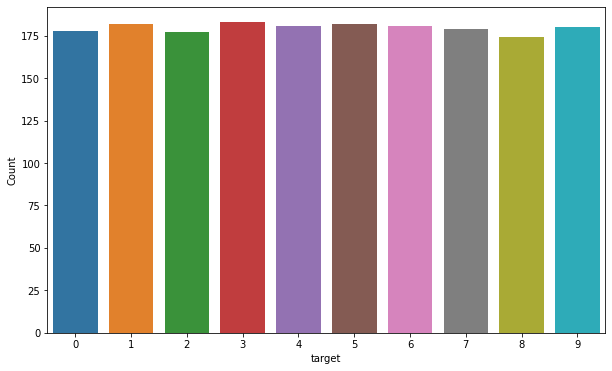

In [96]:
dfcount = digits.groupby('target').apply(lambda x: len(x)).reset_index()
dfcount.columns = ['target','Count']
dfcount
plt.figure(figsize=(10, 6))
sns.barplot(
    x='target',
    y='Count',
    data=dfcount
)
plt.show()

Notamos que no hay preferencia por ningún número

¿Cuánta memoria estoy utilizando? Hasta ahora, notemos que díficilmente se tendrá un conjunto de datos del mismo tamaño que digits

In [97]:
import sys
print('La memoria usada por el dataframe digits es:\n' + str(sys.getsizeof(digits)) + ' bytes')
print('La memoria usada por el dataframe dfcount es:\n' + str(sys.getsizeof(dfcount)) + ' bytes')

La memoria usada por el dataframe digits es:
934600 bytes
La memoria usada por el dataframe dfcount es:
320 bytes


¿Qué tipo de datos son?

In [98]:
digits.dtypes

c00       int64
c01       int64
c02       int64
c03       int64
c04       int64
          ...  
c60       int64
c61       int64
c62       int64
c63       int64
target    int64
Length: 65, dtype: object

digits es un dataframe con datos tipo int

¿Cuántos registros por clase hay? 

In [99]:
digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   c00     1797 non-null   int64
 1   c01     1797 non-null   int64
 2   c02     1797 non-null   int64
 3   c03     1797 non-null   int64
 4   c04     1797 non-null   int64
 5   c05     1797 non-null   int64
 6   c06     1797 non-null   int64
 7   c07     1797 non-null   int64
 8   c08     1797 non-null   int64
 9   c09     1797 non-null   int64
 10  c10     1797 non-null   int64
 11  c11     1797 non-null   int64
 12  c12     1797 non-null   int64
 13  c13     1797 non-null   int64
 14  c14     1797 non-null   int64
 15  c15     1797 non-null   int64
 16  c16     1797 non-null   int64
 17  c17     1797 non-null   int64
 18  c18     1797 non-null   int64
 19  c19     1797 non-null   int64
 20  c20     1797 non-null   int64
 21  c21     1797 non-null   int64
 22  c22     1797 non-null   int64
 23  c23     1797 

1797 con un uso total de 912.7 Kb de memoria

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [100]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

> **Sugerencia**: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

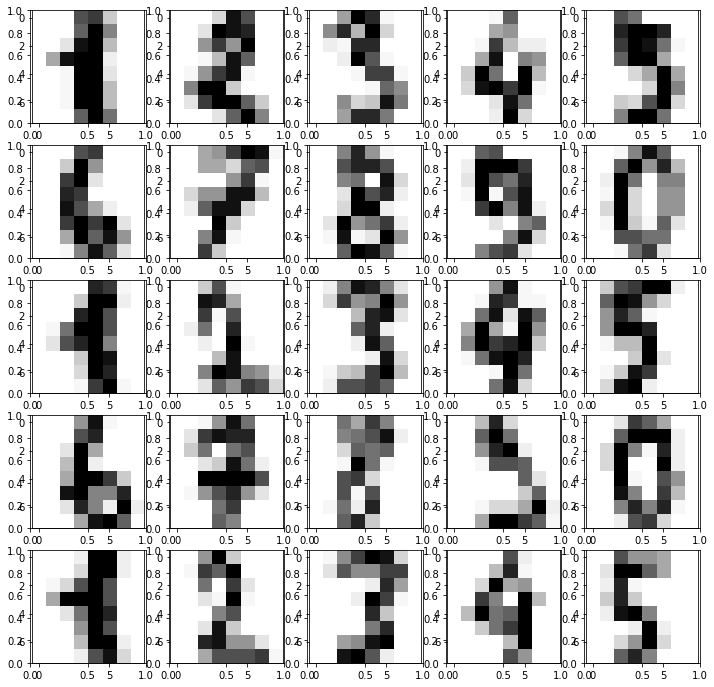

In [101]:
nx, ny = 5,5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))
for i in range(1,26):
    fig.add_subplot(nx, ny, i)
    plt.imshow(digits_dict["images"][i], cmap='Greys')

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


Train-test:

In [102]:
X = digits.drop(columns="target").values
y = digits["target"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)
print('Separando informacion:\n')
print('numero de filas data original : ',len(X))
print('numero de filas train set     : ',len(X_train))
print('numero de filas test set      : ',len(X_test))

Separando informacion:

numero de filas data original :  1797
numero de filas train set     :  1437
numero de filas test set      :  360


Regresión logística:

In [103]:
log = LogisticRegression(solver='liblinear').fit(X_train, y_train)


log_pred = log.predict(X_test)
y_true = y_test

dicc_rlog = {
          'penalty' : ['l1', 'l2'],
          'C' : [100, 10 , 1, 0.1, 0.01, 0.001],
          'class_weight' : ['balanced', None],
          'solver' : ['liblinear'],
          }
grid_log = GridSearchCV(estimator = log, param_grid = dicc_rlog, refit = True, n_jobs=-1) 

start_time = time.time() #Tiempo de inicio 

grid_result_log = grid_log.fit(X_train, y_train)
grid_result_log
print("Tuned Hyperparameters :", grid_result_log.best_params_)
print("Accuracy :",grid_result_log.best_score_)
print("Este modelo se ajustó en",(time.time() - start_time),"segundos.") 

lrg = LogisticRegression(C=0.01, class_weight='balanced', penalty='l2', solver = 'liblinear').fit(X_train, y_train)

lrg_pred = lrg.predict(X_test)
y_true = y_test

accuracylrg = accuracy_score(y_test, lrg_pred)
recalllrg = recall_score(y_test, lrg_pred,average='weighted')
precisionlrg = precision_score(y_test, lrg_pred,average='weighted' )
fscorelrg = f1_score(y_test, lrg_pred,average='weighted')

print('\nMatriz de confusion:\n ')
print(confusion_matrix(y_true,lrg_pred))

print('\nMetricas:\n ')
print('accuracy:   ',accuracylrg)
print('recall:     ',recalllrg)
print('precision:  ',precisionlrg)
print('f-score:    ',fscorelrg)
print("")

Tuned Hyperparameters : {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy : 0.9673006194347658
Este modelo se ajustó en 26.730461835861206 segundos.

Matriz de confusion:
 
[[31  0  0  0  1  0  0  0  0  0]
 [ 0 40  0  1  0  0  1  0  1  1]
 [ 0  0 31  0  0  0  0  0  0  0]
 [ 0  1  0 31  0  1  0  3  0  0]
 [ 0  0  0  0 31  0  0  0  3  1]
 [ 0  0  0  0  0 42  0  0  0  1]
 [ 0  0  0  0  0  0 34  0  1  0]
 [ 0  0  0  0  0  0  0 39  1  0]
 [ 0  2  0  0  0  0  1  0 33  0]
 [ 0  1  0  1  0  1  0  0  2 23]]

Metricas:
 
accuracy:    0.9305555555555556
recall:      0.9305555555555556
precision:   0.9325364988538263
f-score:     0.930622479492183



Kneighbors:

In [104]:
knn = neighbors.KNeighborsClassifier().fit(X_train, y_train)

knn_pred = knn.predict(X_test)
y_true = y_test

dicc_knn = {
          'n_neighbors' : [1,2,3,4,5, 6, 10, 15,30],
          'weights' : ['uniform', 'distance'],
          'metric' : ['euclidean', 'minkowski'],
          'algorithm' : ['auto','brute', 'kd_tree']
          }


grid_knn = GridSearchCV(estimator = knn, param_grid = dicc_knn, cv = 20) 

start_time = time.time() #Tiempo de inicio 

grid_result_knn = grid_knn.fit(X_train, y_train)
print("Tuned Hyperparameters :", grid_knn.best_params_)
print("Accuracy :",grid_knn.best_score_)
print("Este modelo se ajustó en",(time.time() - start_time),"segundos.") 

knng = neighbors.KNeighborsClassifier(algorithm = 'kd_tree', metric= 'euclidean', n_neighbors=3, weights='uniform').fit(X_train, y_train)

knng_pred = knng.predict(X_test)
y_true = y_test

accuracyknn = accuracy_score(y_test, knng_pred)
recallknn = recall_score(y_test, knng_pred,average='weighted')
precisionknn = precision_score(y_test, knng_pred,average='weighted' )
fscoreknn = f1_score(y_test, knng_pred,average='weighted')

print('\nMatriz de confusion:\n ')
print(confusion_matrix(y_true,knng_pred))

print('\nMetricas:\n ')
print('accuracy:   ',accuracyknn)
print('recall:     ',recallknn)
print('precision:  ',precisionknn)
print('f-score:    ',fscoreknn)
print("")

Tuned Hyperparameters : {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Accuracy : 0.9874902190923318
Este modelo se ajustó en 33.962870836257935 segundos.

Matriz de confusion:
 
[[32  0  0  0  0  0  0  0  0  0]
 [ 0 44  0  0  0  0  0  0  0  0]
 [ 0  0 31  0  0  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  1  0  0]
 [ 0  0  0  0 33  0  0  1  1  0]
 [ 0  0  0  0  0 43  0  0  0  0]
 [ 0  0  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  0]
 [ 0  1  0  0  0  0  0  0 35  0]
 [ 0  0  0  0  0  0  0  1  0 27]]

Metricas:
 
accuracy:    0.9861111111111112
recall:      0.9861111111111112
precision:   0.98675423485501
f-score:     0.986150805326889



Random Forest:

In [105]:
rfc =  RandomForestClassifier(n_estimators=100).fit(X_train,y_train)

y_true =  y_test
rfc_pred = rfc.predict(X_test)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
 

rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model

start_time = time.time()
rfc_random.fit(X_train, y_train)
print("Este modelo se ajustó en",(time.time() - start_time),"segundos.") 
print(rfc_random.best_params_)

rfcg =  RandomForestClassifier(n_estimators=144,min_samples_split=2,min_samples_leaf=2,max_features='auto',max_depth=60, bootstrap=False).fit(X_train,y_train)

y_true =  y_test
rfcg_pred = rfcg.predict(X_test)

accuracyrfc = accuracy_score(y_true, rfcg_pred)
recallrfc = recall_score(y_true, rfcg_pred,average='weighted')
precisionrfc = precision_score(y_true, rfcg_pred,average='weighted')
fscorerfc = f1_score(y_true, rfcg_pred,average='weighted')

print('\nMatriz de confusion:\n ')
print(confusion_matrix(y_true,knn_pred))

print('\nMetricas:\n ')
print('accuracy:   ',accuracyrfc)
print('recall:     ',recallrfc)
print('precision:  ',precisionrfc)
print('f-score:    ',fscorerfc)
print("")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: ignored

El mejor modelo para cada métrica fue KNN, elegimos KNN.

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

Cross Validation:

In [ ]:
scores = cross_val_score(estimator = knn, X = X_train, y = y_train, cv = 10)
print(scores) 

m=scores.mean()
s=scores.std()*2
print('El intervalo de confianza es:\n', m ,"±",s)

Curva de Validación:

In [ ]:
param_range = np.array([i for i in range (1,10)])
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(algorithm = 'kd_tree', metric= 'euclidean', n_neighbors=3, weights='uniform').fit(X_train, y_train),
    X_train,
    y_train,
    param_name="n_neighbors",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=1,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.97, 1.01)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [ ]:
from sklearn.preprocessing import LabelBinarizer

y_score = knn.fit(X_train, y_train).predict_proba(X_test)

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

class_id = np.flatnonzero(y, classes=digits["target"].unique())
class_id



### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


In [ ]:
k = 20 # número de atributos a seleccionar
x_training = digits.drop(["c00","c32","c39","target"], axis = 1) #00, 32, 39 dan errores
y_training = digits["target"]

columnas = list(x_training.columns.values)
seleccionadas = SelectKBest(f_classif, k=k).fit(x_training, y_training)

ratr = seleccionadas.get_support()
atributos = [columnas[i] for i in list(ratr.nonzero()[0])]
atribs=list(atributos)
print(atribs)

# Creando el modelo
Xr = digits.drop(columns="target").values
yr = digits["target"].values
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.15, random_state=150)


knn0 = KNeighborsClassifier()
knn0.fit(Xr_train, yr_train) # ajustando el modelo

predicciones = knn0.predict(Xr_test)

df_pred = pd.DataFrame({
    'y':yr_test,
    'yhat':predicciones
})

df_s1 = summary_metrics(df_pred).assign(name = 'Every variable')

# Entrenamiento con las variables seleccionadas
Xc = digits[atributos]
y = digits['target']


# split dataset
Xc_train, X_test, yc_train, y_test = train_test_split(Xc, y, test_size=0.15, random_state = 150) 

# Creando el modelo
knn1 = KNeighborsClassifier()
knn1.fit(Xc_train, yc_train) # ajustando el modelo

prediccionesb = knn1.predict(X_test)

df_pred = pd.DataFrame({
    'y':y_test,
    'yhat':prediccionesb
})

df_s2 = summary_metrics(df_pred).assign(name = 'Selected Variables')


pd.concat([df_s1,df_s2])

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [ ]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = (y_pred == y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = (y_pred != y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = y_test[mask]
    y_aux_pred = y_pred[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
            ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

## II.- California Housing Prices


<img src="https://www.wartsila.com/images/default-source/default-album/california_housing.tmb-1920x690.jpg?sfvrsn=126bc44_1" width="480" height="240" align="center"/>

Los datos se refieren a las casas encontradas en un distrito determinado de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Tenga en cuenta que los datos no se limpian, por lo que se requieren algunos pasos de procesamiento previo.

Las columnas son las siguientes, sus nombres se explican por sí mismos:

* longitude
* latitude
* housingmedianage
* total_rooms
* total_bedrooms
* population
* households
* median_income
* medianhousevalue
* ocean_proximity


El objetivo es poder predecir el valor promedio de cada propiedad. 
Para poder completar correctamente este laboratorio, es necesario seguir la siguiente rúbrica de trabajo:

1. Definición del problema
2. Estadística descriptiva
3. Visualización descriptiva
4. Preprocesamiento
5. Selección de modelo 
    1. Por lo menos debe comparar cuatro modelos
    2. Al menos tres de estos modelos tienen que tener hiperparámetros.
    3. Realizar optimización de hiperparámetros.
6. Métricas y análisis de resultados
7. Visualizaciones del modelo
8. Conclusiones

> **Observación**: Puede tomar como referencia lo realizado en la sección **I.- Clasificación de dígitos**. El alumno tiene la libertad de desarrollar un análisis más completo del problema (si así lo desea). Puede tomar como referencia el siguiente [link](https://www.kaggle.com/camnugent/california-housing-prices).

In [117]:
# read data
housing = pd.read_csv('data/housing.csv',sep=',')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Estadística descriptiva básica:

In [118]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [119]:
housing.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [120]:
housing["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [121]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Visualización de datos de cada columna:

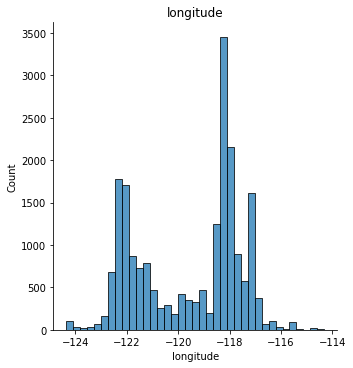

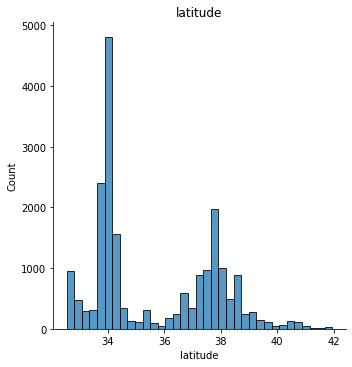

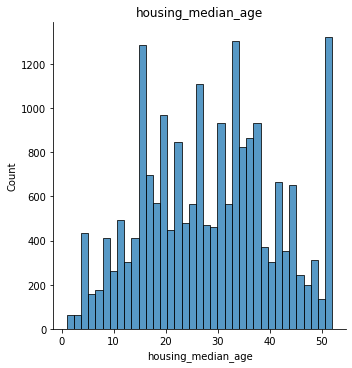

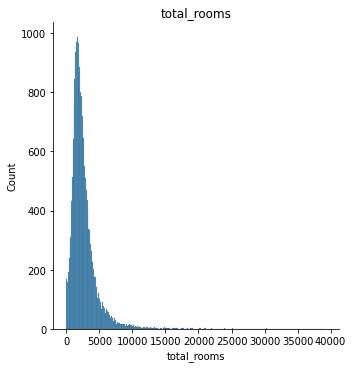

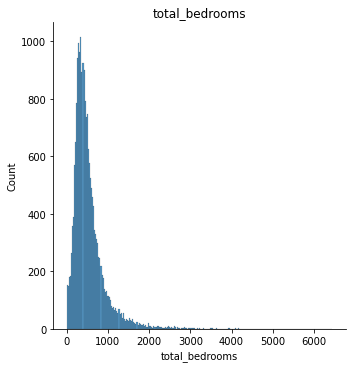

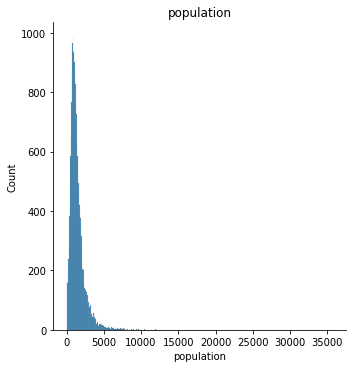

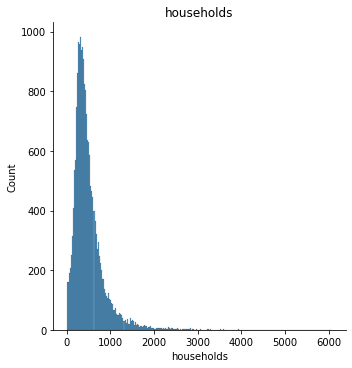

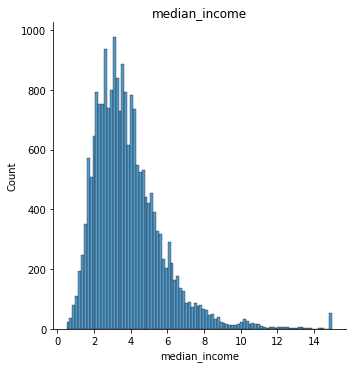

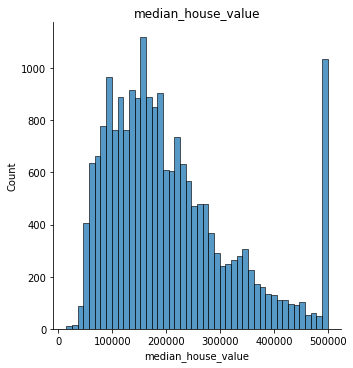

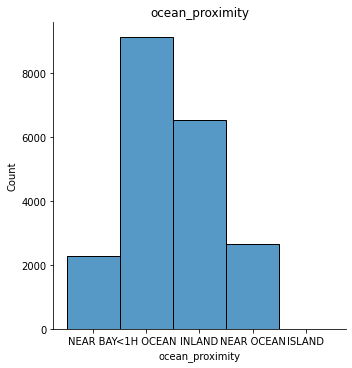

In [122]:
for i in range(10):
    sns.displot(housing[housing.columns[i]])
    plt.title(housing.columns[i])